# all converted to MongoDB

In [31]:
from pymongo import MongoClient

# Connect to your MongoDB instance
client = MongoClient('mongodb://localhost:27017/')
db = client['vaers']  
collection = db['reports']  

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


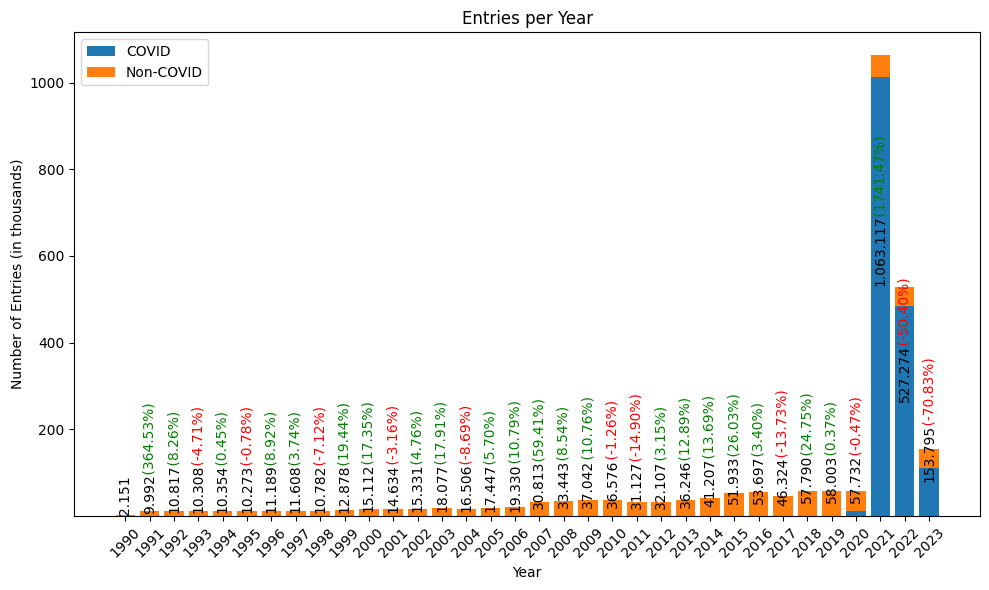

In [55]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Custom formatter function
def thousands_formatter(x, pos):
    return f'{int(x / 1000)}'

def format_with_dot(num):
    return f'{num:,}'.replace(',', '.')

# MongoDB aggregation pipeline
pipeline = [
    {
        "$match": {
            "RECVDATE": {"$exists": True},  # Filter out documents without RECVDATE
        }
    },
    {
        "$group": {
            "_id": {
                "year": {"$year": "$RECVDATE"},
                "is_covid": {"$anyElementTrue": {"$map": {
                    "input": "$vax_data",
                    "as": "vax_entry",
                    "in": {"$regexMatch": {"input": "$$vax_entry.VAX_TYPE", "regex": "covid", "options": "i"}}
                }}}
            },
            "count": {"$sum": 1}  # Count the number of documents
        }
    },
    {
        "$group": {
            "_id": "$_id.year",
            "counts": {
                "$push": {
                    "is_covid": "$_id.is_covid",
                    "count": "$count"
                }
            }
        }
    },
    {
        "$project": {
            "_id": 0,
            "year": "$_id",
            "counts": 1
        }
    }
]

# Execute the aggregation pipeline
result = collection.aggregate(pipeline)

# Process the result
entries_per_year = {}
for document in result:
    year = document['year']
    counts = {entry['is_covid']: entry['count'] for entry in document['counts']}
    entries_per_year[year] = counts

# Convert the dictionary to lists for plotting
years = sorted(entries_per_year.keys())
counts_covid = [entries_per_year[year].get(True, 0) for year in years]
counts_non_covid = [entries_per_year[year].get(False, 0) for year in years]
total_counts = [sum(counts) for counts in zip(counts_covid, counts_non_covid)]

# Calculate percentage change relative to the previous year
pct_change = [0] + [((total_counts[i] - total_counts[i-1]) / total_counts[i-1]) * 100 for i in range(1, len(total_counts))]

# Plotting the data as stacked bar plot
plt.figure(figsize=(10, 6))
bars1 = plt.bar(years, counts_covid, label='COVID')
bars2 = plt.bar(years, counts_non_covid, bottom=counts_covid, label='Non-COVID')

# Annotate each bar with its value
for year, total_count in zip(years, total_counts):
    plt.text(year, total_count / 2, format_with_dot(total_count),
             ha='center', va='bottom', rotation=90)  # Neutral color for the total number


    # Annotate each bar with its percentage change relative to the previous year
for year, total_count, pct in zip(years[1:], total_counts[1:], pct_change[1:]):
    color = 'green' if pct > 0 else 'red'
    if total_count < 10000:
        yoffset = 80000
    elif total_count < 100000:
        yoffset = 100000
    elif total_count < 1000000:
        yoffset = 120000
    else:
        yoffset = 150000
    plt.text(year, total_count / 2 + yoffset, f" ({pct:.2f}%)",
             ha='center', va='bottom', rotation=90, color=color)

# Set the y-axis formatter
formatter = FuncFormatter(thousands_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.xlabel('Year')
plt.ylabel('Number of Entries (in thousands)')
plt.title('Entries per Year')
plt.xticks(years, rotation=45)
plt.legend()



plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Entries_per_Year/Entries_per_Year_stacked.eps', format='eps')
plt.show()


# Number of Entries per Year

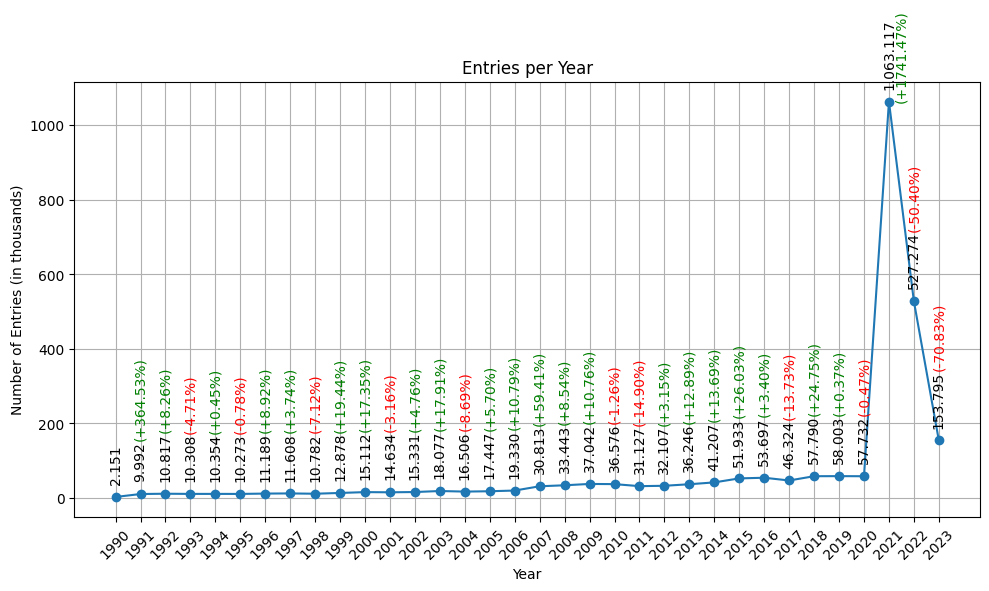

In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Custom formatter function
def thousands_formatter(x):
    return f'{int(x / 1000)}'

def format_with_dot(num):
    return f'{num:,}'.replace(',', '.')

# Initialize a dictionary to store the number of entries per year
entries_per_year = {}

# Query the database for documents
documents_cursor = collection.find({}, {"RECVDATE": 1})

# Process documents to count entries per year
for document in documents_cursor:
    recv_date = document.get('RECVDATE')
    if recv_date:
        year = recv_date.year
        entries_per_year[year] = entries_per_year.get(year, 0) + 1

# Convert the dictionary to lists for plotting
years = list(entries_per_year.keys())
counts = list(entries_per_year.values())

# Calculate percentage change
pct_change = [0]  # Start with 0 for the first year
for i in range(1, len(counts)):
    change = ((counts[i] - counts[i-1]) / counts[i-1]) * 100
    pct_change.append(change)

# Plotting the data as a line graph
plt.figure(figsize=(10, 6))
plt.plot(years, counts, marker='o', linestyle='-', label='Number of Entries')
plt.xlabel('Year')
plt.ylabel('Number of Entries (in thousands)')
plt.title('Entries per Year')

# Set the y-axis formatter
formatter = FuncFormatter(thousands_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Annotate each point with its value and percentage change
for i, (year, count, pct_change) in enumerate(zip(years, counts, pct_change)):
    formatted_value = format_with_dot(count)

    # Annotate with the count value in default color, larger font size, and rotated 90 degrees
    plt.annotate(formatted_value, (year, count + 5000), textcoords="offset points", xytext=(0, 10),
                 ha='center', fontsize=10, rotation=90)

    color = 'black'
    if pct_change != 0:
        color = 'green' if pct_change > 0 else 'red'
        
    # Determine the offset based on the count
    if count < 10000:
        offset = 115500
        xoffset = 0 
    elif count < 100000:
        offset = 135000
        xoffset = 0
    elif count < 600000:
        offset = 160000
        xoffset = 0
    else:
        offset = -30000  # Adjust the offset to the right
        xoffset = 0.5
    
    if i != 0:
        # Annotate with the percentage change in colored text, larger font size, and rotated 90 degrees
        plt.annotate(f"({pct_change:+.2f}%)", (year + xoffset, count + offset), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, rotation=90, color=color)



plt.xticks(years, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Entries_per_Year/Entries_per_Year_dotted.png')
plt.show()

 # Number of COVID19 Vaccine Entries per Year

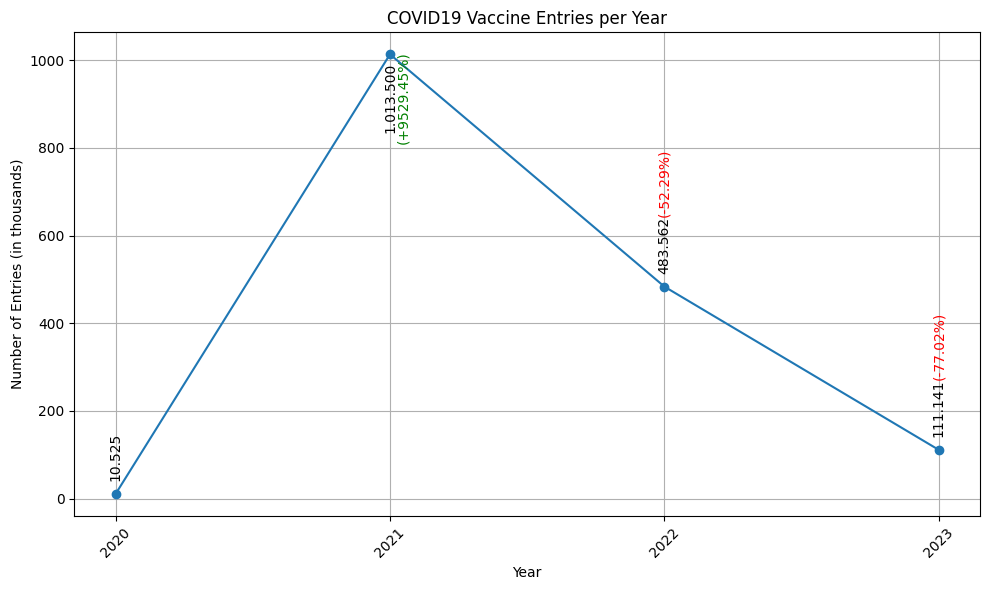

In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from datetime import datetime

# Custom formatter function
def thousands_formatter(x):
    return f'{int(x / 1000)}'

def format_with_dot(num):
    return f'{num:,}'.replace(',', '.')

# Initialize a dictionary to store the number of entries per year
entries_per_year = {}

# Query the database for documents within the range of years 2020-2023 and containing "COVID" in VAX_TYPE
query = {
    "vax_data.VAX_TYPE": {"$regex": "COVID", "$options": "i"},
    "RECVDATE": {"$gte": datetime(2020, 1, 1), "$lte": datetime(2023, 12, 31)}
}
documents_cursor = collection.find(query, {"RECVDATE": 1})

# Process documents to count entries per year
for document in documents_cursor:
    recv_date = document.get('RECVDATE')
    if recv_date:
        year = recv_date.year
        entries_per_year[year] = entries_per_year.get(year, 0) + 1

# Convert the dictionary to lists for plotting
years = list(entries_per_year.keys())
counts = list(entries_per_year.values())

# Calculate percentage change
pct_change = [0]  # Start with 0 for the first year
for i in range(1, len(counts)):
    change = ((counts[i] - counts[i-1]) / counts[i-1]) * 100
    pct_change.append(change)

# Plotting the data as a line graph
plt.figure(figsize=(10, 6))
plt.plot(years, counts, marker='o', linestyle='-', label='Number of Entries')
plt.xlabel('Year')
plt.ylabel('Number of Entries (in thousands)')
plt.title('COVID19 Vaccine Entries per Year')

# Set the y-axis formatter
formatter = FuncFormatter(thousands_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Annotate each point with its value and percentage change
for i, (year, count, pct_change) in enumerate(zip(years, counts, pct_change)):
    formatted_value = format_with_dot(count)
    
    offset = 5000
    # Annotate with the count value
    if year == 2021: 
        offset = -205000

    plt.annotate(formatted_value, (year, count + offset), textcoords="offset points", xytext=(0, 10),
                 ha='center', fontsize=10, rotation=90)

    color = 'black'
    if pct_change != 0:
        color = 'green' if pct_change > 0 else 'red'
        
    # Determine the offset based on the count
    if count < 100000:
        offset = 115000
        xoffset= 0 
    elif 100000 <= count < 650000:
        offset = 135000
        xoffset= 0
    else:
        offset = -230000
        xoffset= 0.05
    
    if i != 0:
        # Annotate with the percentage change in colored text, larger font size, and rotated 90 degrees
        plt.annotate(f"({pct_change:+.2f}%)", (year + xoffset, count + offset), textcoords="offset points", xytext=(0, 10),
                     ha='center', fontsize=10, rotation=90, color=color)

plt.xticks(years, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Entries_per_Year/COVID19_Entries_per_Year_dotted.png')
plt.show()
